## 1. Import data & useful libraries
## 2. Analyse and prepare data
### A. Dataset analyse
### B. Outliers
### C. Missing data
### D. More feature engineering
### E. Encoding of categorical features
## 3. Applying classification algorithms
### A. Validation method
### B. Comparing models
### C. Create submitting file

# 1. Import data & useful libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, KFold
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier

import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

In [2]:
train = pd.read_csv('../input/titanic/train.csv')
test = pd.read_csv('../input/titanic/test.csv')

# 2. Analyse and prepare data 

## A. Dataset analyse

In [3]:
train.shape

(891, 12)

In [4]:
test.shape

(418, 11)

Ok, so we have 12 features (including the one to predict). We have data about 891 people in the train set and 418 in the test set.

In [5]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
#Save the 'Id' column
train_ID = train['PassengerId']
test_ID = test['PassengerId']

# Remove 'Id' for analysis
train = train.drop('PassengerId', axis=1)
test = test.drop('PassengerId', axis=1)

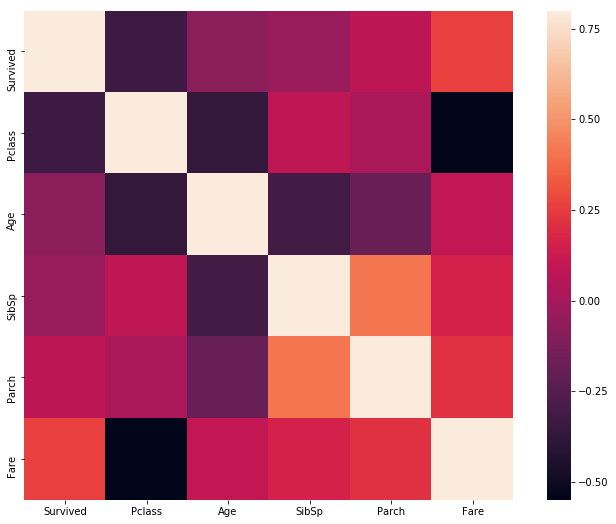

In [7]:
#correlation matrix
corrmat = train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

## B. Outliers

In [8]:
train.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [9]:
train['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [10]:
train['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

It seems that there is no outliers !

## C. Missing data

In [11]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.Survived.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['Survived'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (1309, 10)


In [12]:
#display top missing data ratio
total = all_data.isnull().sum().sort_values(ascending=False)
percent = (all_data.isnull().sum()/all_data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
Cabin,1014,0.774637
Age,263,0.200917
Embarked,2,0.001528
Fare,1,0.000764
Ticket,0,0.000000
SibSp,0,0.000000
Sex,0,0.000000
Pclass,0,0.000000
Parch,0,0.000000
Name,0,0.000000


* **Cabin**

The huge majority of data for this feature is missing and it does not bring a lot of information for our predictions. So, I decide to remove this column.

In [13]:
all_data.drop(['Cabin'], axis=1, inplace=True)

* **Age**

We could replace the 263 missing values by mean or median. But let's check if we can do something a little bit smarter. On the correlation matrix, we can notice that Pclass and SibSp are strongly correlated to the age. Let's explore this idea.

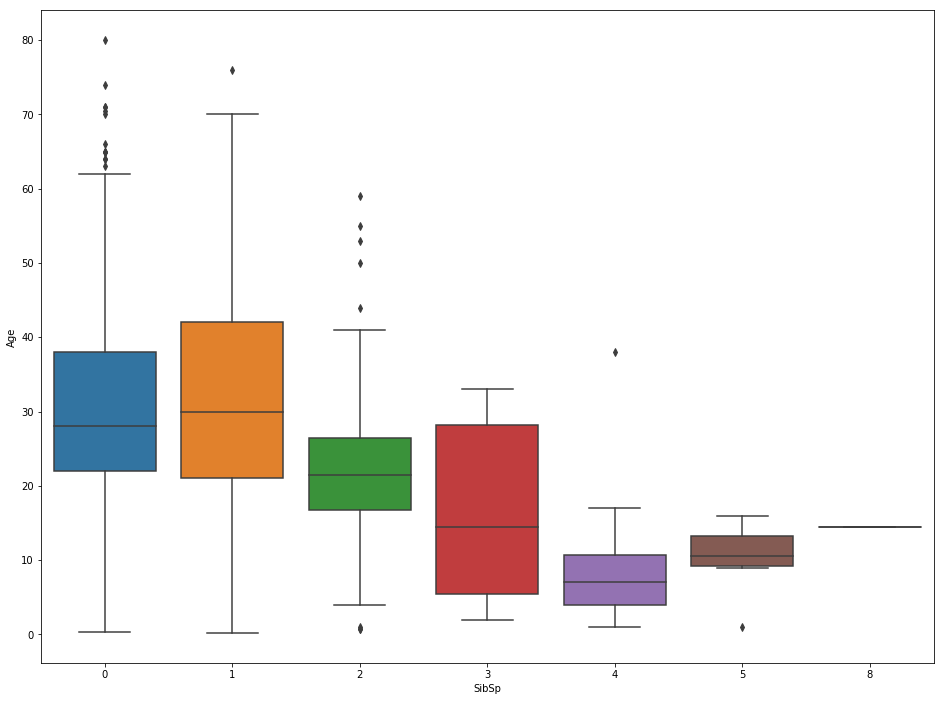

In [14]:
#box plot Pclass/Age
var = 'SibSp'
data = pd.concat([all_data['Age'], all_data[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 12))
fig = sns.boxplot(x=var, y="Age", data=data)

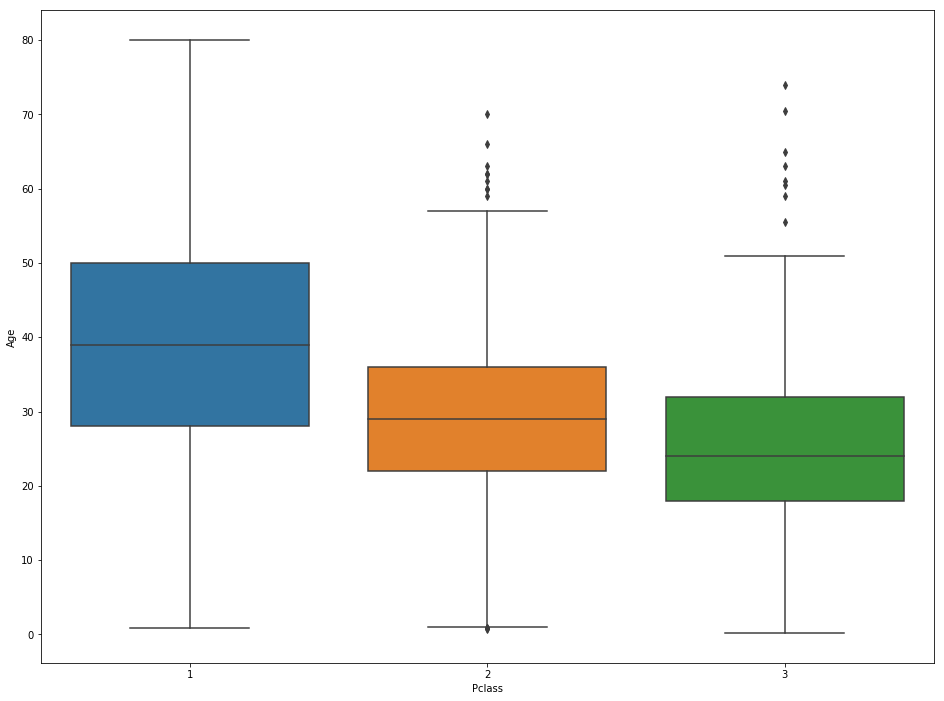

In [15]:
#box plot Pclass/Age
var = 'Pclass'
data = pd.concat([all_data['Age'], all_data[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 12))
fig = sns.boxplot(x=var, y="Age", data=data)

Waouh ! It seems that from 2 sibling and spouse, the average age is becoming very lower ! It seems normal, you don't usely travel that much with your whole brothers and sisters when you are adult.
Let's first fill in the blanks by the median of the given SibSp, for SibSp > 1.
For the others, I fill in the blanks by the median of the given Pclass.

In [16]:
all_data['SibSp'].loc[np.isnan(all_data['Age'])].value_counts()

0    206
1     39
8      8
2      6
3      4
Name: SibSp, dtype: int64

In [17]:
all_data["Age"] = all_data.loc[all_data["SibSp"]>1].groupby("SibSp")["Age"].transform(
    lambda x: x.fillna(x.median()))

In [18]:
all_data["Age"] = all_data.groupby("Pclass")["Age"].transform(
    lambda x: x.fillna(x.median()))

* **Embarked**

In [19]:
all_data["Embarked"].value_counts()

S    914
C    270
Q    123
Name: Embarked, dtype: int64

I fill in the blank by the most common value

In [20]:
all_data["Embarked"] = all_data["Embarked"].fillna("S")

* **Fare**

The fare mainly depends on pclass

In [21]:
all_data["Fare"] = all_data.groupby("Pclass")["Fare"].transform(
    lambda x: x.fillna(x.median()))

## D. More feature engineering

In [22]:
all_data["TotalRelatives"] = all_data['SibSp'] + all_data['Parch']

all_data['IsAlone'] = 1 #initialize to yes/1 is alone
all_data['IsAlone'].loc[all_data["TotalRelatives"] > 0] = 0 # now update to no/0 if family size is greater than 1

#quick and dirty code split title from name: http://www.pythonforbeginners.com/dictionary/python-split
all_data['Title'] = all_data['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]


#Continuous variable bins; qcut vs cut: https://stackoverflow.com/questions/30211923/what-is-the-difference-between-pandas-qcut-and-pandas-cut
#Fare Bins/Buckets using qcut or frequency bins: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.qcut.html
all_data['FareBin'] = pd.qcut(all_data['Fare'], 4)

#Age Bins/Buckets using cut or value bins: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.cut.html
all_data['AgeBin'] = pd.cut(all_data['Age'].astype(int), 5)

## E. Encoding of categorical features

In [23]:
final_features = pd.get_dummies(all_data).reset_index(drop=True)
final_features.shape

(1309, 2275)

# 3. Applying classification algorithms

In [24]:
train = final_features[:ntrain]
test = final_features[ntrain:]

## A. Validation method

In [25]:
#Validation function
n_folds = 5

def score_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    score = cross_val_score(model, train.values, y_train, cv = kf)
    return("score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

## B. Comparing models

* **GaussianNB**

In [26]:
score_cv(GaussianNB())

'score: 0.4703 (0.0286)'

* **LogisticRegression**

In [27]:
params = {'logisticregression__C' : [0.001,0.01,0.1,1,10,100,1000]}
pipe = make_pipeline(RobustScaler(), LogisticRegression())
gridsearch_logistic = GridSearchCV (pipe, params, cv=10)
gridsearch_logistic.fit(train, y_train)
print ("Meilleurs parametres: ", gridsearch_logistic.best_params_)

Meilleurs parametres:  {'logisticregression__C': 100}


In [28]:
score_cv(gridsearch_logistic.best_estimator_)

'score: 0.8373 (0.0175)'

* **KNeighborsClassifier**

In [29]:
params = {'kneighborsclassifier__n_neighbors' : [3,4,5,6,7],
         'kneighborsclassifier__weights' : ['uniform','distance'],
         'kneighborsclassifier__algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute']}
pipe = make_pipeline(RobustScaler(), KNeighborsClassifier())
gridsearch_KNC = GridSearchCV (pipe, params, cv=5)
gridsearch_KNC.fit(train, y_train)
print ("Meilleurs parametres: ", gridsearch_KNC.best_params_)

Meilleurs parametres:  {'kneighborsclassifier__algorithm': 'auto', 'kneighborsclassifier__n_neighbors': 6, 'kneighborsclassifier__weights': 'distance'}


In [30]:
score_cv(gridsearch_KNC.best_estimator_)

'score: 0.8183 (0.0243)'

* **XGBClassifier**

In [31]:
score_cv(XGBClassifier())

'score: 0.8249 (0.0297)'

* **GradientBoostingClassifier**

In [32]:
gradient = GradientBoostingClassifier()
gradient.fit(train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [33]:
score_cv(GradientBoostingClassifier())

'score: 0.8238 (0.0152)'

In [34]:
params = {
    "loss":["deviance"],
    "learning_rate": [0.01, 0.05, 0.1, 0.15, 0.2],
    "min_samples_split": np.linspace(0.1, 0.5, 4),
    "min_samples_leaf": np.linspace(0.1, 0.5, 4),
    "max_depth":[3,5,8],
    "max_features":["auto","log2","sqrt"],
    "criterion": ["friedman_mse",  "mae"],
    "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    "n_estimators":[100]
    }
gridsearch_gradient = RandomizedSearchCV (GradientBoostingClassifier(), params, n_iter = 500, cv=5)
gridsearch_gradient.fit(train, y_train)
print ("Meilleurs parametres: ", gridsearch_gradient.best_params_)

Meilleurs parametres:  {'subsample': 0.85, 'n_estimators': 100, 'min_samples_split': 0.1, 'min_samples_leaf': 0.1, 'max_features': 'auto', 'max_depth': 5, 'loss': 'deviance', 'learning_rate': 0.2, 'criterion': 'friedman_mse'}


In [35]:
score_cv(gridsearch_gradient.best_estimator_)

'score: 0.8115 (0.0219)'

## C. Create submitting file

In [36]:
pred = gridsearch_logistic.best_estimator_.predict(test)
sub = pd.DataFrame()
sub['PassengerID'] = test_ID
sub['Survived'] = pred
sub.to_csv('submission.csv',index=False)

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 